# Regression with a modular simulation model
* The semi empirical rudder is not part of the regression, but needs to be subtracted from the left hand side.
* Now also with propeller model
* And wind system

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from vessel_manoeuvring_models.models.propeller import *
from vessel_manoeuvring_models.models.semiempirical_rudder import SemiempiricalRudderSystem
from vessel_manoeuvring_models.models.wind_force import WindForceSystem
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator
from vessel_manoeuvring_models.models.subsystem import PrimeEquationSubSystem, EquationSubSystem
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models import prime_system
from vessel_manoeuvring_models.models.modular_simulator import subs_simpler
import statsmodels.api as sm

import inspect
from sympy.printing import pretty
p = df_parameters["symbol"]

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series")
time_series_smooth = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)
model_loader = catalog.load(f"{ship}.models")

[06/09/23 12:03:25] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=362570;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=792713;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[06/09/23 12:03:36] INFO     Kedro project phd                                                      ]8;id=765848;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=244965;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=459441;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=191210;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=712520;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=73945;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series' (PartitionedDataSet)...       ]8;id=65821;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=17934;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=694062;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=193922;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=912014;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=424162;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=690105;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=956613;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=13502;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=861321;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=789386;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=783299;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
model= model_loader["MDL_modular_propeller_rudder"]()

In [5]:
ship_data_7m = catalog.load(f"7m.ship_data")

[06/09/23 12:03:37] INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=726424;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=410644;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [6]:
ship_data['A_XV'] = ship_data_7m['A_XV']*ship_data_7m['scale_factor']**2/(ship_data['scale_factor']**2)
ship_data['A_YV'] = ship_data_7m['A_YV']*ship_data_7m['scale_factor']**2/(ship_data['scale_factor']**2)
ship_data['rho_A'] = ship_data_7m['rho_A']
model.ship_parameters.update(ship_data)

In [7]:
#A_XV: 1.120  # Transverse projected area above the waterline including superstructures
#A_YV: 6.037  # Longitudinal projected area above the waterline including superstructures
#rho_A: 1.225 # Mass density of air [kg/m3]

In [8]:
data = time_series_smooth['wpcc.updated.22773.ek_smooth']()
#data = time_series_smooth['wpcc.updated.22774.ek_smooth']()
data['V'] = data['U'] = np.sqrt(data['u']**2 + data['v']**2)
data['rev'] = data[['Prop/SB/Rpm', 'Prop/PS/Rpm']].mean(axis=1)
data['twa'] = 0
data['tws'] = 0


In [9]:
result = model.simulate(data)

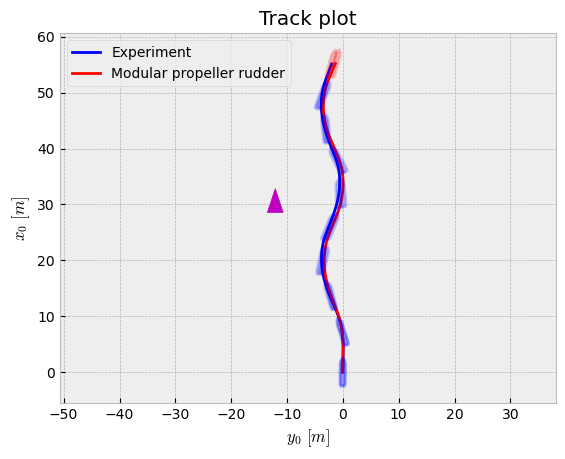

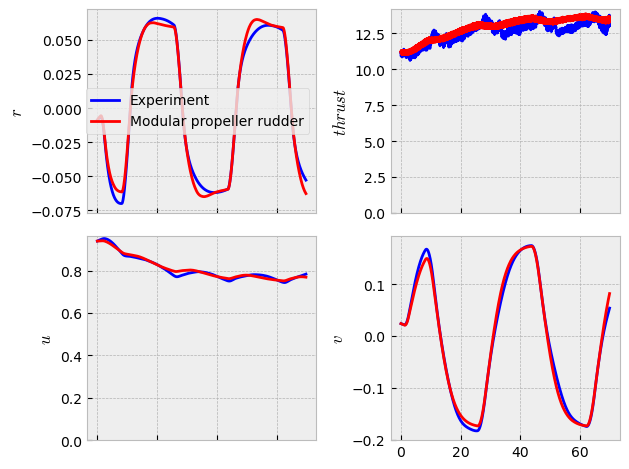

In [10]:
dataframes = {
              'Experiment':data,
              'Modular propeller rudder':result,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [11]:
model.subsystems

{'propellers': <vessel_manoeuvring_models.models.subsystem.EquationSubSystem at 0x7effe11792d0>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7effe1039870>,
 'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7effe109f3a0>}

In [12]:
wind_force = WindForceSystem(ship=model, create_jacobians=False)

In [13]:
wind_force.lambdas['awa']

<function vessel_manoeuvring_models.models.wind_force.WindForceSystem.__init__.<locals>.awa_signed_angle(U, cog, psi, twa, tws)>

In [14]:
for eq in wind_force.equations.values():
    display(eq)

Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi)))

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

Eq(X_W, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa))

Eq(Y_W, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A)

Eq(N_W, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)

In [15]:
wind_force.equations['aws']

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [16]:
def function_eq(eq):
    return sp.Eq(sp.Function(eq.lhs)(*list(eq.rhs.free_symbols)),eq.rhs)        

In [17]:
function_eq(wind_force.equations['aws'])

Eq(aws(cog, U, twa, tws), sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [18]:
wind_force.equations['awa']

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

In [19]:
from vessel_manoeuvring_models.apparent_wind import *
V

(U*cos(cog))*N.i + (U*sin(cog))*N.j

In [20]:
V_S = u * S.i + v * S.j
V_S

u*S.i + v*S.j

In [21]:
V_N = express(V_S,N)
V_N

(u*cos(\Psi) - v*sin(\Psi))*N.i + (u*sin(\Psi) + v*cos(\Psi))*N.j

In [22]:
V_N.dot(N.j)

u*sin(\Psi) + v*cos(\Psi)

In [23]:
V_N.dot(N.i)

u*cos(\Psi) - v*sin(\Psi)

In [24]:
sp.simplify(sp.atan(V_N.dot(N.j) / (V_N.dot(N.i))).diff(u))

-v/(u**2 + v**2)

In [25]:
eq_cog = sp.Eq(cog,sp.atan2(V_N.dot(N.j), (V_N.dot(N.i))))
eq_cog

Eq(cog, atan2(u*sin(\Psi) + v*cos(\Psi), u*cos(\Psi) - v*sin(\Psi)))

In [26]:
sp.simplify(eq_cog.rhs.diff(u))

-v/(u**2 + v**2)

## Coefficients

In [27]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)
wind_data_HMD.index=360-wind_data_HMD.index
wind_data_HMD.index = np.deg2rad(wind_data_HMD.index)
wind_data_HMD.index = np.mod(wind_data_HMD.index + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = wind_data_HMD.index
wind_data_HMD.index.name = "awa [rad]"
wind_data_HMD.sort_index(inplace=True)

In [28]:
from vessel_manoeuvring_models.models.wind_force import eq_C_x, eq_C_y, eq_C_n, C_x, C_y, C_n

In [29]:
eq_to_matrix_C_x = DiffEqToMatrix(eq_C_x, label=C_x, base_features=[awa])
eq_to_matrix_C_y = DiffEqToMatrix(eq_C_y, label=C_y, base_features=[awa])
eq_to_matrix_C_n = DiffEqToMatrix(eq_C_n, label=C_n, base_features=[awa])

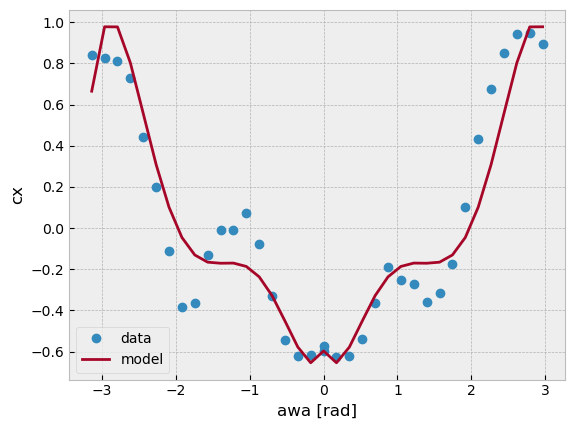

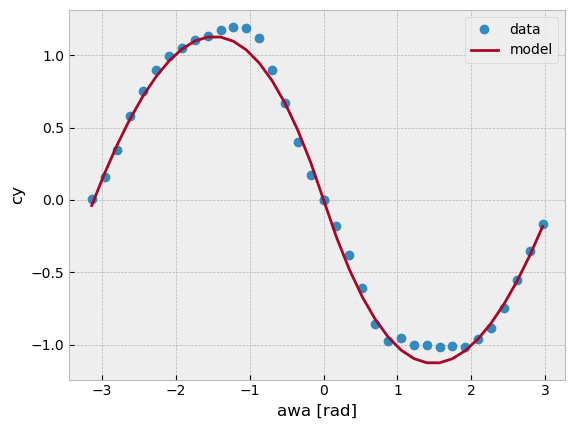

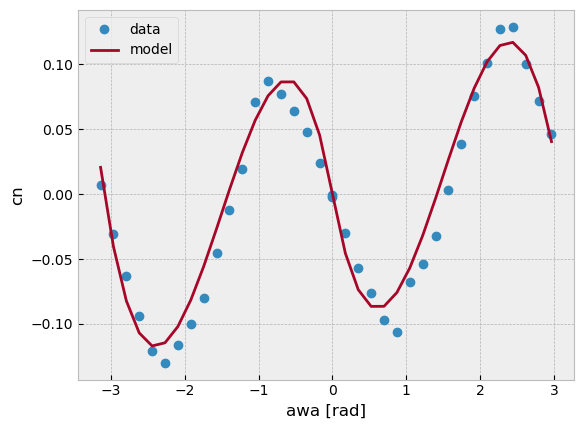

In [30]:
params_wind = {}
for key,eq_to_matrix in zip(['cx','cy','cn'], [eq_to_matrix_C_x, eq_to_matrix_C_y, eq_to_matrix_C_n]):

    X,y = eq_to_matrix.calculate_features_and_label(data=wind_data_HMD, y=wind_data_HMD[key], simplify_names=False)
    ols = sm.OLS(y,X, hasconst=False)
    ols_fit = ols.fit()
    params_wind.update(ols_fit.params)
    
    fig,ax=plt.subplots()
    y.plot(ax=ax,style='o', label='data')
    y_pred = ols_fit.predict(X)
    y_pred.plot(ax=ax, label='model')
    ax.set_ylabel(key)
    ax.legend()

## Build ship model

In [31]:
function_eq(wind_force.equations['X_W']).lhs

X_W(C_x2, C_x4, C_x1, C_x5, aws, A_XV, C_x3, C_x0, rho_A, awa)

In [32]:
X_eq = sp.Eq(model.X_eq.lhs, model.X_eq.rhs + function_eq(wind_force.equations['X_W']).lhs)
Y_eq = sp.Eq(model.Y_eq.lhs, model.Y_eq.rhs + function_eq(wind_force.equations['Y_W']).lhs)
N_eq = sp.Eq(model.N_eq.lhs, model.N_eq.rhs + function_eq(wind_force.equations['N_W']).lhs)

In [33]:
parameters = model.parameters.copy()
parameters.update(params_wind)
ship_parameters = model.ship_parameters.copy()
ship_parameters.update(ship_data)

In [34]:
model_wind = model.copy()
model_wind.__init__(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq, 
                    parameters=parameters, 
                    ship_parameters=ship_parameters, 
                    control_keys=['delta','rev','twa','tws'], # NOTE! 
                    do_create_jacobian=False)
model_wind.subsystems

{'propellers': <vessel_manoeuvring_models.models.subsystem.EquationSubSystem at 0x7effe0cfab60>,
 'rudders': <vessel_manoeuvring_models.models.semiempirical_rudder.SemiempiricalRudderSystem at 0x7effe0cf9de0>,
 'hull': <vessel_manoeuvring_models.models.subsystem.PrimeEquationSubSystem at 0x7effe0cfb670>}

In [35]:
assert model_wind.subsystems['propellers'].ship == model_wind
assert model_wind.subsystems['propellers'].ship != model


In [36]:
model_wind.subsystems['wind_force'] = wind_force.copy_and_refer_other_ship(ship=model_wind)

In [37]:
result_wind = model_wind.simulate(data)

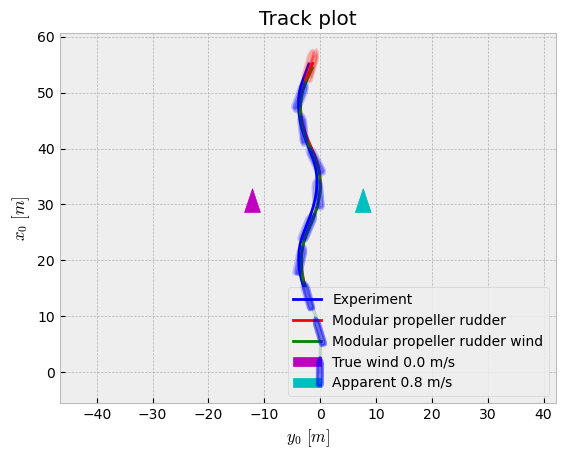

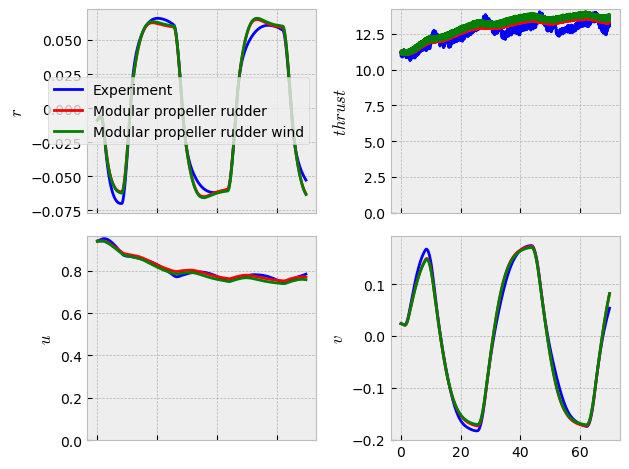

In [38]:
dataframes = {
              'Experiment':data,
              'Modular propeller rudder':result,
              'Modular propeller rudder wind':result_wind,
             }
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=10)
plot(dataframes, keys=['u','v','r','thrust']);

In [39]:
result_wind.head()

,u,v,r,x0,y0,psi,u1d,v1d,r1d,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,X_H,Y_H,N_H,cog,aws,awa,X_W,Y_W,N_W,X_D,Y_D,N_D,beta,U
0.00,0.939222,0.023695,-0.008880,-0.002863,-0.037007,0.007873,0.000187,-0.002385,0.003641,11.271166,9.952440,1.144697,-0.037457,-0.056504,-1.013584,2.455102,-9.326026,-4.149080,1.830808,0.033096,0.939521,0.025223,-0.396730,-0.136954,-0.134644,0.173180,-5.299618,4.151266,-0.025223,0.939521
0.01,0.939224,0.023671,-0.008843,0.006527,-0.036697,0.007784,0.000224,-0.002396,0.003622,11.288367,9.967628,1.145247,-0.037359,-0.056506,-1.011905,2.451035,-9.325757,-4.146630,1.812000,0.032982,0.939523,0.025198,-0.396720,-0.136818,-0.134512,0.188644,-5.295353,4.128524,-0.025198,0.939523
0.02,0.939227,0.023647,-0.008807,0.015917,-0.036388,0.007696,0.000187,-0.002404,0.003600,11.269294,9.950787,1.144639,-0.037287,-0.056416,-1.008865,2.443671,-9.325501,-4.144153,1.793326,0.032868,0.939525,0.025172,-0.396710,-0.136681,-0.134379,0.172159,-5.289698,4.102619,-0.025172,0.939525
0.03,0.939228,0.023623,-0.008771,0.025308,-0.036080,0.007608,0.000008,-0.002410,0.003574,11.181076,9.872890,1.141822,-0.037286,-0.056161,-1.003898,2.431640,-9.325226,-4.141643,1.774804,0.032755,0.939525,0.025146,-0.396698,-0.136543,-0.134246,0.094804,-5.282083,4.072198,-0.025146,0.939525
0.04,0.939229,0.023599,-0.008736,0.034698,-0.035772,0.007521,0.000056,-0.002420,0.003555,11.203410,9.892611,1.142536,-0.037171,-0.056171,-1.002048,2.427159,-9.324935,-4.139101,1.756430,0.032641,0.939525,0.025121,-0.396686,-0.136404,-0.134112,0.114819,-5.277553,4.049476,-0.025121,0.939525


<Axes: >

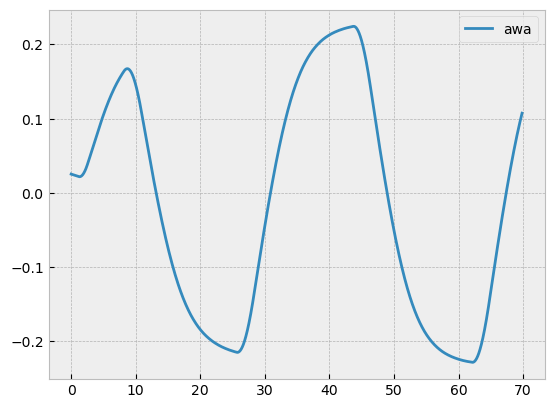

In [40]:
result_wind.plot(y='awa')

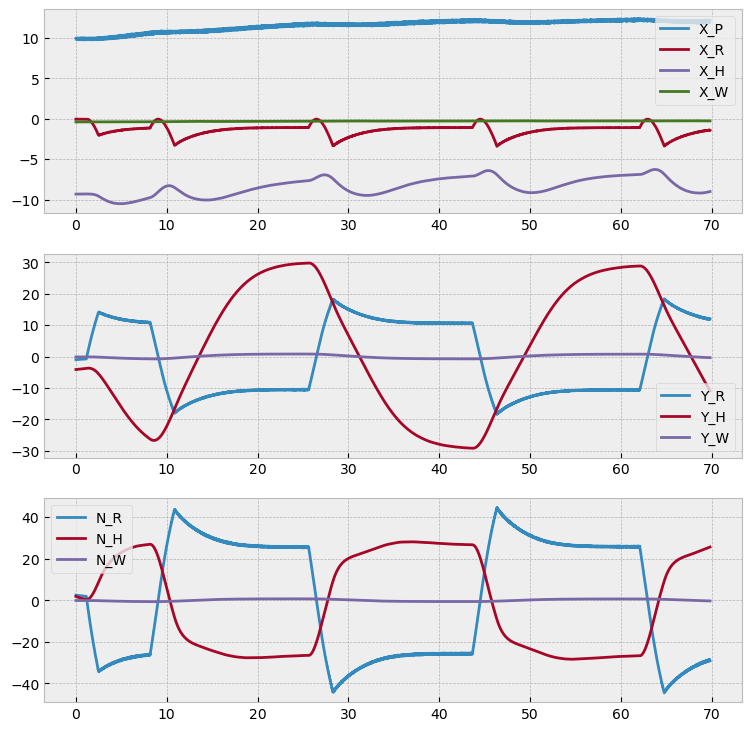

In [41]:
fig,axes=plt.subplots(nrows=3)
fig.set_size_inches(9,9)
for ax,key in zip(axes,['X','Y','N']):
    mask = result_wind.columns.str.contains(key)
    columns = list(result_wind.columns[mask])
    columns.remove(f'{key}_D')
    result_wind.plot(y=columns,ax=ax)

In [42]:
ship_data

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151,
 'n_prop': 2,
 'A_XV': 0.5938354227542653,
 'A_YV': 3.2008789706852667,
 'rho_A': 1.225}

In [43]:
result_wind['C_x'] = result_wind['X_W'] / (result_wind['aws']**2*ship_data['A_XV']*ship_data['rho_A'])
result_wind['C_y'] = result_wind['Y_W'] / (result_wind['aws']**2*ship_data['A_YV']*ship_data['rho_A'])
result_wind['C_n'] = result_wind['N_W'] / (result_wind['aws']**2*ship_data['A_YV']*ship_data['L']*ship_data['rho_A'])

<Axes: xlabel='awa'>

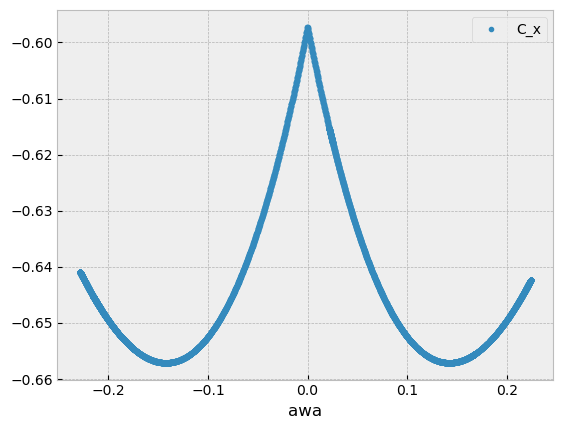

In [44]:
result_wind.plot(x='awa', y='C_x', style='.')

<Axes: xlabel='awa'>

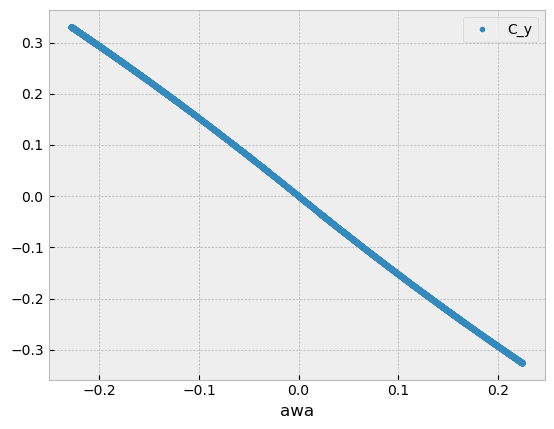

In [45]:
result_wind.plot(x='awa', y='C_y', style='.')

<Axes: xlabel='awa'>

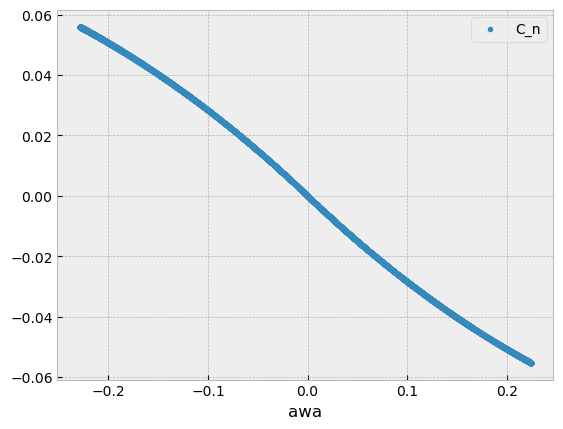

In [46]:
result_wind.plot(x='awa', y='C_n', style='.')